# Using HPA segmentation tool

From https://github.com/CellProfiling/HPA-Cell-Segmentation

Below is a demonstration of installing and using this segmentation tool on some of the downloaded images above.

In [1]:
!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

     / 17 kB 206 kB/s
     | 131 kB 98 kB/s
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14939 sha256=671cc08fd8d92a946861fae4fdefaac254a400bc505523872b178e29e75f7493
  Stored in directory: /tmp/pip-ephem-wheel-cache-atg726hv/wheels/cd/d8/de/04ad08802d62537f8dffc89b6a7ce0a53c3d29ea6eae522ab1
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=e373b37ff17a5f575dc51dd8e89a5a9104741a850a0f216c7dd4b02d7111d327
  Stored in directory: /tmp/pip-ephem-wheel-cache-atg726hv/wheels/58/0e/c7/567928a140c7cb2533c59bdc81fded8fe720ea8caad1659d8c
Successfully built hpacellseg pytorch-zoo
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os

In [3]:
%cd /kaggle

/kaggle


In [4]:
save_dir = 'publichpa_masks'
os.makedirs(save_dir, exist_ok=True)

In [5]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
import glob
import imageio

In [6]:
NUC_MODEL = "./nuclei-model.pth"
CELL_MODEL = "./cell-model.pth"
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=True,
    multi_channel_model=True,
)

Could not find ./nuclei-model.pth. Downloading it now


please compile abn


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [7]:
mt = glob.glob('/kaggle/input/humanpro-publichpa-grey/publichpa/*_red.png')
er = [f.replace('red', 'yellow') for f in mt]
nu = [f.replace('red', 'blue') for f in mt]
print(len(mt))

1964


In [8]:
nsample = 1964

In [9]:
%%time

batch_size = 10

for ib in range(0, nsample, batch_size):
    images = [mt[ib:ib + batch_size], er[ib:ib + batch_size], nu[ib:ib + batch_size]]

    # For nuclei
    nuc_segmentations = segmentator.pred_nuclei(images[2])

    # For full cells
    cell_segmentations = segmentator.pred_cells(images)

    # post-processing
    for i, pred in enumerate(cell_segmentations):
        nuclei_mask, cell_mask = label_cell(nuc_segmentations[i], cell_segmentations[i])
        FOVname = os.path.basename(mt[ib + i]).replace('red','predictedmask')
        imageio.imwrite(os.path.join(save_dir,FOVname), cell_mask) 

/opt/conda/lib/python3.7/site-packages/hpacellseg/utils.py:143: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nuclei_label = remove_small_objects(nuclei_label, 2500)
/opt/conda/lib/python3.7/site-packages/hpacellseg/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cell_label = remove_small_objects(cell_label, 5500).astype(np.uint8)
/opt/conda/lib/python3.7/site-packages/hpacellseg/utils.py:175: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cell_label = remove_small_objects(cell_label, 5500)
/opt/conda/lib/python3.7/site-packages/hpacellseg/utils.py:180: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nuclei_label = remove_small_objects(nuclei_label, 2500)


CPU times: user 3h 54min 28s, sys: 3min 47s, total: 3h 58min 16s
Wall time: 4h 2min 54s


In [10]:
1964 / 10 * 1.25 / 60

4.091666666666667

(2048, 2048) (2048, 2048) (2048, 2048) (2048, 2048)
(1728, 1728) (1728, 1728) (1728, 1728) (1728, 1728)
(2048, 2048) (2048, 2048) (2048, 2048) (2048, 2048)


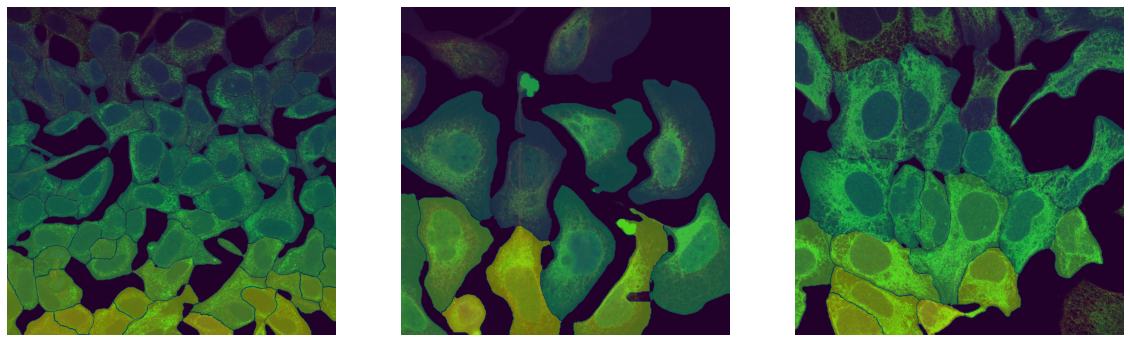

In [11]:
# Visualizing the segmentation masks we just predicted above

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    mask = plt.imread(os.path.join(save_dir, os.path.basename(mt[i]).replace('red','predictedmask')))
    print(microtubule.shape, endoplasmicrec.shape, nuclei.shape, mask.shape)
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    ax[i].imshow(img)
    ax[i].imshow(mask, alpha=0.5)
    ax[i].axis('off')
plt.show()

In [12]:
%cd /kaggle
!zip -rq publichpa_masks.zip publichpa_masks/
! cp publichpa_masks.zip /kaggle/working/.
%cd /kaggle

/kaggle
/kaggle


In [13]:
! du -hs /kaggle/working/*

636K	/kaggle/working/__notebook__.ipynb
53M	/kaggle/working/publichpa_masks.zip
